### Packages

In [1]:
###Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Import

In [2]:
df = pd.read_csv("DataTrain-2.csv")

#### Check for null values

In [3]:
# Checking which columns have any null values
columns_with_nulls = df.isnull().any()

# Filtering to show only columns with null values
columns_with_nulls_true = columns_with_nulls[columns_with_nulls].index.tolist()

print("Columns with null values:", columns_with_nulls_true)

Columns with null values: []


NO null values

#### Create a new column RUL 

In [4]:
# Creating a new column with the max 'cycle' per 'engine_id'
df['max_cycle_per_engine'] = df.groupby('engine_id')['cycle'].transform('max')
# Creating the 'cycles_left' column
df['RUL'] = df['max_cycle_per_engine'] - df['cycle']

### Remove features with zero variance

In [5]:
# Calculating variance for each column
variances = df.var()

# Identifying columns with zero variance
zero_variance_columns = variances[variances == 0].index.tolist()

print("Columns with zero variance:", zero_variance_columns)

# Filtering out columns with zero variance
df = df.loc[:, variances > 0]

Columns with zero variance: ['set1', 'sensor_val7', 'sensor_val11', 'sensor_val14', 'sensor_val16']


## Make a Correlation Matrix

                      engine_id     cycle      set2      set3  sensor_val1  \
engine_id              1.000000  0.078753 -0.017895 -0.006197    -0.052053   
cycle                  0.078753  1.000000 -0.004527  0.016132     0.443999   
set2                  -0.017895 -0.004527  1.000000  0.011660    -0.004279   
set3                  -0.006197  0.016132  0.011660  1.000000    -0.005425   
sensor_val1           -0.052053  0.443999 -0.004279 -0.005425     1.000000   
sensor_val2           -0.031882 -0.611354 -0.001491 -0.010923    -0.210238   
sensor_val3           -0.059473  0.370324 -0.004469 -0.006310     0.963157   
sensor_val4            0.012621  0.543947 -0.005651  0.009068     0.322964   
sensor_val5           -0.032073 -0.595914 -0.009437 -0.016678    -0.217835   
sensor_val6           -0.020589 -0.583597 -0.005713 -0.010554    -0.285280   
sensor_val8                 NaN       NaN       NaN       NaN          NaN   
sensor_val9            0.044230  0.477523  0.002318  0.018156   

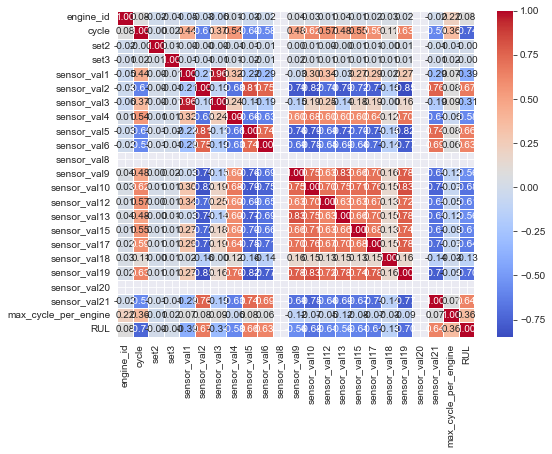

In [9]:
# Calculating the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualizing the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

In [10]:
rul_correlations = correlation_matrix['RUL']

# Display the correlations of 'RUL' with other features
print(rul_correlations)

engine_id               0.078753
cycle                  -0.736241
set2                   -0.003198
set3                   -0.001948
sensor_val1            -0.390102
sensor_val2             0.671983
sensor_val3            -0.306769
sensor_val4            -0.584520
sensor_val5             0.657223
sensor_val6             0.629428
sensor_val8                  NaN
sensor_val9            -0.562569
sensor_val10           -0.678948
sensor_val12           -0.606154
sensor_val13           -0.563968
sensor_val15           -0.606484
sensor_val17           -0.642667
sensor_val18           -0.128348
sensor_val19           -0.696228
sensor_val20                 NaN
sensor_val21            0.635662
max_cycle_per_engine    0.363152
RUL                     1.000000
Name: RUL, dtype: float64


In [11]:
df.var()

engine_id               8.542545e+02
cycle                   4.744591e+03
set2                    4.784340e-06
set3                    8.588541e-08
sensor_val1             4.876536e+02
sensor_val2             5.439850e-01
sensor_val3             3.639005e+02
sensor_val4             3.759099e+01
sensor_val5             7.833883e-01
sensor_val6             3.266927e-02
sensor_val8             1.926023e-34
sensor_val9             5.172330e-03
sensor_val10            8.101089e+01
sensor_val12            2.398667e+00
sensor_val13            5.038938e-03
sensor_val15            2.500533e-01
sensor_val17            1.406628e-03
sensor_val18            1.929279e-06
sensor_val19            7.133568e-02
sensor_val20            3.155597e-30
sensor_val21            1.171825e-02
max_cycle_per_engine    2.502861e+03
RUL                     4.744591e+03
dtype: float64